# Validação do modelo

## Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
palette = 'mako'

from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_absolute_error as mae

In [40]:
feature_list = ['corrente_atrasada', 'corrente_principal', 'potencia_atrasado', 'estado_semana', 'carga_leve']

In [41]:
df = pd.read_pickle('../datasets/processed.pkl')
df.drop(columns = 'segundos_depois_meia_noite', inplace = True)

df = pd.concat([df, pd.get_dummies(df.tipo_carga)], axis = 1).drop(columns = 'tipo_carga')

def rename_columns(column: str):
    column = column.replace(' ', '_')
    return column.lower()

for column_list in df.columns[-3:].tolist():
    df.rename(columns = {column_list: rename_columns(column_list)}, inplace = True)
del rename_columns

df = df.groupby(df['data'].dt.date).agg({
    'consumo_energia': 'mean',
    'corrente_atrasada': 'mean',
    'corrente_principal': 'mean',
    'potencia_atrasado': 'mean',
    'carga_leve': 'sum',
    'estado_semana': lambda x: x.mode()[0],
}).reset_index()

df.data = pd.to_datetime(df.data)
for item in df.select_dtypes('object').columns:
    df[item] = LabelEncoder().fit_transform(df[item])

In [42]:
features = df
target = df.consumo_energia

In [43]:
def test_model(list_of_months: list, features: pd.DataFrame, target: pd.Series) -> tuple:
    features = features.copy()
    target = target.copy()
    
    idx_train = features[~features.data.dt.month.isin(list_of_months)].drop(columns = ['data']).index
    idx_test = features[features.data.dt.month.isin(list_of_months)].drop(columns = ['data']).index
    features.drop(columns = ['data'], inplace = True)
    
    x_train, x_test, y_train, y_test = features.loc[idx_train], features.loc[idx_test], target.loc[idx_train], target.loc[idx_test]
    
    model = joblib.load('../models/final_model.pkl')
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    return list_of_months, pred, y_test

def create_scores(month_to_start: int) -> pd.DataFrame:
    score = {
        'r2': [],
        'mae': []
    }
    
    for i in range (month_to_start, 1, -1):
        to_test = list(range(i, 13))
        _, pred, y_test = test_model(to_test, features, target)
        score['r2'].append(r2_score(y_test, pred))
        score['mae'].append(mae(y_test, pred))
        
    return pd.DataFrame(score, index=range(month_to_start, 1, -1))

In [44]:
def create_plot(results: pd.DataFrame, n_rows = 2, n_cols = 1) -> None:
    fig = plt.figure(figsize=(20, 10))
    for column in results.columns:
        ax = fig.add_subplot(n_rows, n_cols, results.columns.get_loc(column)+1)
        sns.lineplot(x = results.index, y = results[column].values, ax = ax)
        ax.set_title(column.title())
        ax.set_xlabel('Até qual mês foi utilizado para teste')
        ax.set_ylabel(column)
    plt.tight_layout()

Utilizando nosso modelo final (SVR), foi plotada o R2_Score do modelo, e em seguida seu Erro Absoluto Médio (MAE).

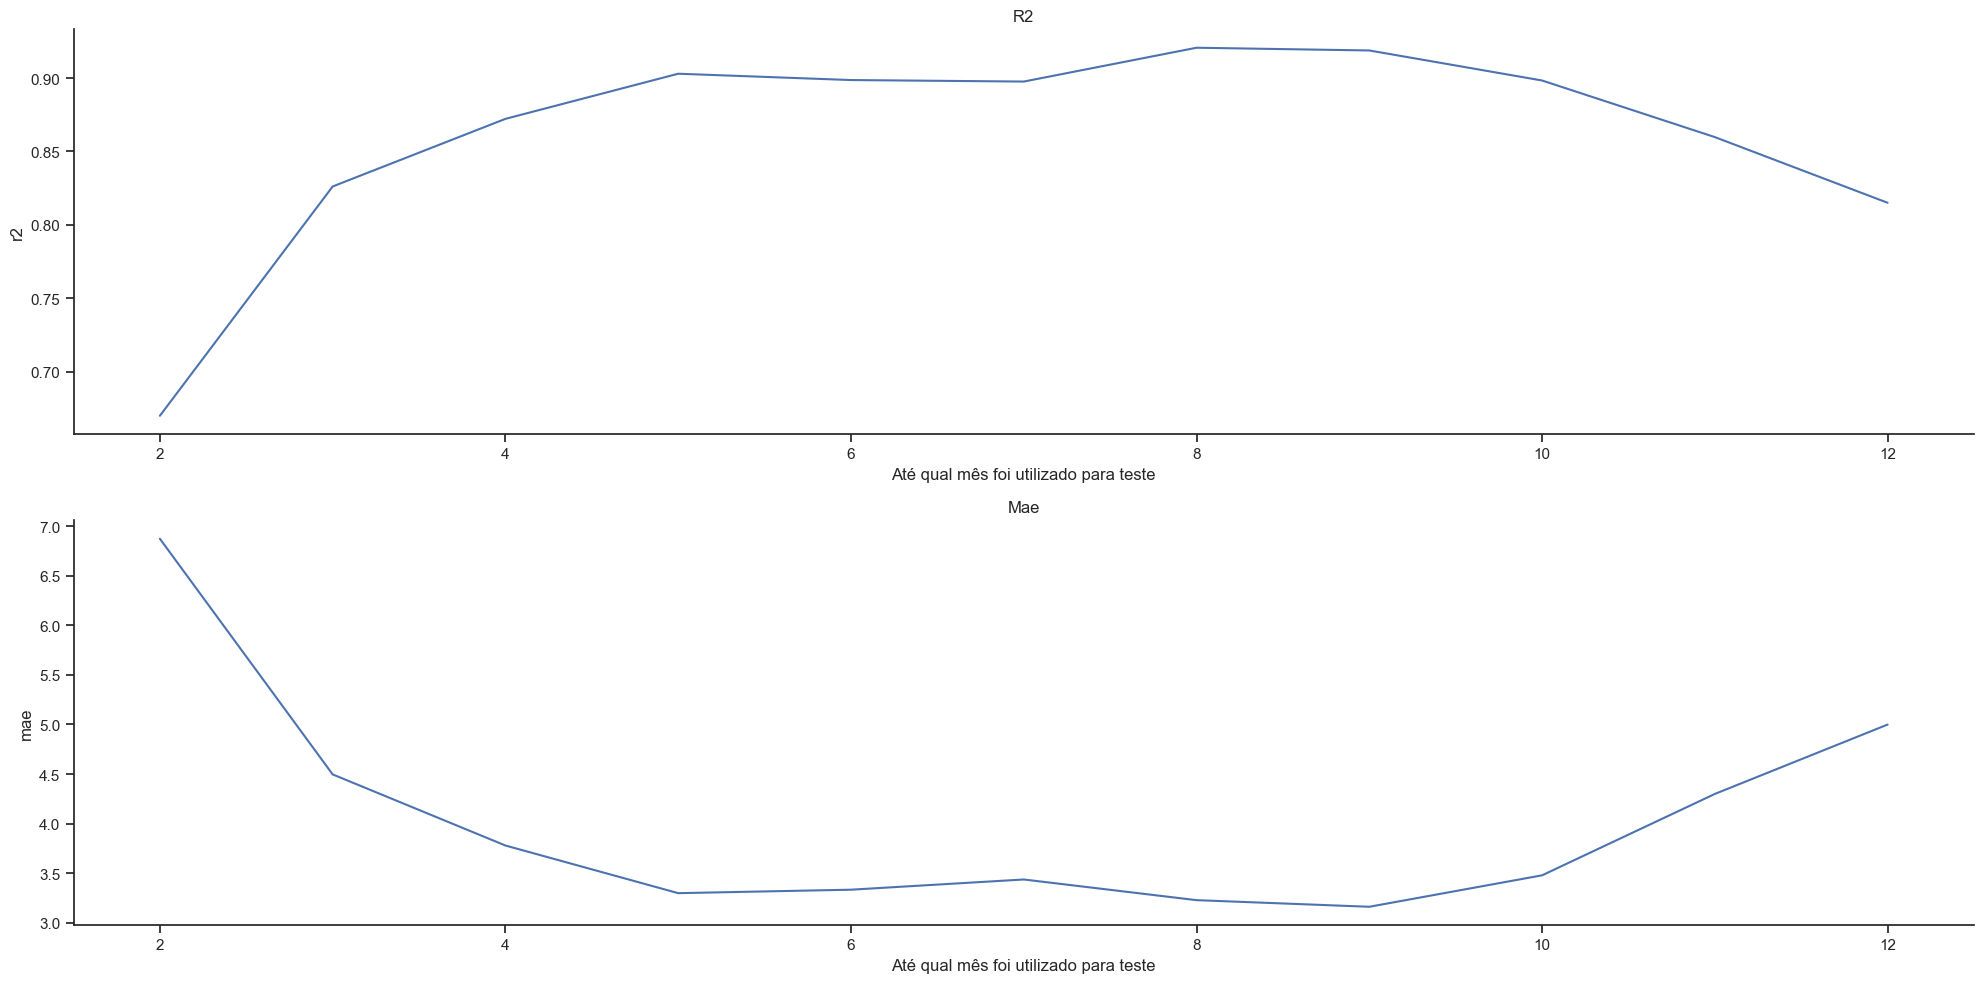

In [45]:
score = create_scores(12)
create_plot(score)
plt.show()

O efeito observado é que ao utilizar para treino os dados de Janeiro até Agosto, e para teste os dados de Setembro, em diante, o modelo apresenta um R2_Score alto e um MAE baixo.

## Conclusão

Pode-se concluir que o modelo é capaz de prever o consumo de energia de dois até três meses para frente com uma boa precisão e baixo erro.